In [1]:
from pymilvus import MilvusClient

# Kết nối tới Milvus server
milvus_client = MilvusClient(uri="http://localhost:19530")

# Kiểm tra kết nối bằng cách liệt kê collection
try:
    collections = milvus_client.list_collections()
    print("Kết nối thành công! Danh sách collection:", collections)
except Exception as e:
    print("Kết nối thất bại:", str(e))

Kết nối thành công! Danh sách collection: ['image_collection', 'text_image_video_collection']


In [3]:
# Tạo collection
collection_name = "image_collection"

# Xóa collection nếu đã tồn tại (nếu muốn bắt đầu lại)
if milvus_client.has_collection(collection_name):
    milvus_client.drop_collection(collection_name)

# Tạo collection mới
milvus_client.create_collection(
    collection_name=collection_name,
    dimension=512,  # Chiều dài vector từ CLIP (ViT-B/32)
    auto_id=True,   # Tự động tạo ID
    enable_dynamic_field=True,  # Hỗ trợ field động (như filepath)
)

# Kiểm tra lại danh sách collection
collections = milvus_client.list_collections()
print("Danh sách collection:", collections)

Danh sách collection: ['image_collection']


In [7]:
# -------------------------
# 1. Import thư viện cần thiết
# -------------------------
import open_clip                         # open-clip-torch, CPU-only
from PIL import Image
import torch

# -------------------------
# 2. Tải mô hình CLIP (CPU)
# -------------------------
model_name = "ViT-B-32"
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained='openai')
model.eval()                             # Chỉ inference
device = "cpu"
model.to(device)

# ---------------------------------------
# 3. Hàm mã hóa ảnh thành vector
# ---------------------------------------
def encode_image(image_path):
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)  # Tiền xử lý + batch
    with torch.no_grad():
        image_features = model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)     # Normalize
    return image_features.squeeze().tolist()

# ---------------------------------------
# 4. Hàm mã hóa text thành vector
# ---------------------------------------
def encode_text(text):
    text_tokens = open_clip.tokenize([text]).to(device)                  # Tokenize
    with torch.no_grad():
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)       # Normalize
    return text_features.squeeze().tolist()


/home/shared/CODE_cua_Thuan/milvus_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/shared/CODE_cua_Thuan/milvus_env/lib/python3.13/site-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


In [ ]:
import os
from glob import glob

image_dir = "/home/shared/CODE_cua_Thuan/KEY1" # Thư mục chứa ảnh (dataset)
raw_data = []  # Danh sách lưu vector + đường dẫn ảnh
batch_size = 20  # Giảm xuống 10 ảnh/lần
    
for image_path in glob(os.path.join(image_dir, "**/*.jpg"), recursive=True): # Duyệt tất cả ảnh đuôi .JPEG (bao gồm sub-folder)
    image_embedding = encode_image(image_path) # Mã hóa ảnh thành vector bằng CLIP
    image_dict = {"vector": image_embedding, "filepath": image_path}
    raw_data.append(image_dict)
    
    if len(raw_data) >= batch_size:
        insert_result = milvus_client.insert(collection_name="image_collection", data=raw_data) # Tên collection trong Milvus
        print(f"Đã chèn {insert_result['insert_count']} ảnh.")
        raw_data = []  # Reset danh sách

# Chèn phần còn lại
if raw_data:
    insert_result = milvus_client.insert(collection_name="image_collection", data=raw_data)
    print(f"Đã chèn {insert_result['insert_count']} ảnh còn lại.")

Đã chèn 20 ảnh.
Đã chèn 20 ảnh.
Đã chèn 20 ảnh.
Đã chèn 20 ảnh.
Đã chèn 20 ảnh.
Đã chèn 20 ảnh.
Đã chèn 20 ảnh.
Đã chèn 20 ảnh.
Đã chèn 20 ảnh.
Đã chèn 20 ảnh.
Đã chèn 20 ảnh.
Đã chèn 20 ảnh.
Đã chèn 20 ảnh.
Đã chèn 20 ảnh.
Đã chèn 20 ảnh.
Đã chèn 20 ảnh.
Đã chèn 20 ảnh.
Đã chèn 20 ảnh.
Đã chèn 20 ảnh.
Đã chèn 20 ảnh.
Đã chèn 20 ảnh.
Đã chèn 20 ảnh.
Đã chèn 20 ảnh.
Đã chèn 20 ảnh.
Đã chèn 20 ảnh.
Đã chèn 20 ảnh.
Đã chèn 20 ảnh.
Đã chèn 20 ảnh.
Đã chèn 9 ảnh còn lại.


Query text: Ventricity on the shake there are many cars

Search results:


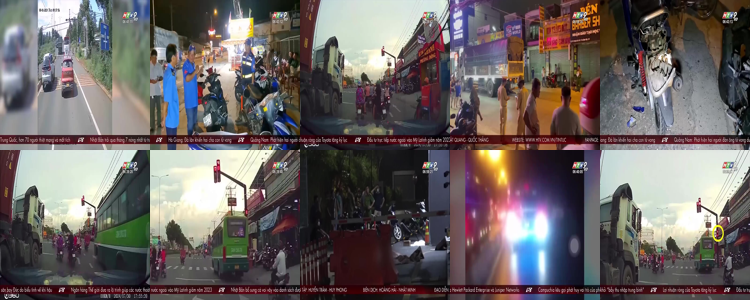

In [10]:
from deep_translator import GoogleTranslator

text_vi = "vu chay lon o tren rung co nhieu xe cuu hoa"
translator = GoogleTranslator(source='vi', target='en')
text_en = translator.translate(text_vi)


query_text = text_en                    # Câu truy vấn (ví dụ: tìm chó Doberman)
query_embedding = encode_text(query_text)   # Mã hóa text thành vector bằng CLIP

search_results = milvus_client.search(
    collection_name="image_collection",    # Tên collection đã tạo trong Milvus
    data=[query_embedding],             # Vector query (nên để list, vì có thể search nhiều query một lúc)
    limit=10,                           # Trả về top 10 kết quả gần nhất
    output_fields=["filepath"],         # Ngoài vector similarity, trả thêm thông tin đường dẫn ảnh
)

from IPython.display import display   # Dùng để hiển thị ảnh trực tiếp trong notebook/JupyterLab
from PIL import Image                 # Thư viện xử lý ảnh (mở, resize, ghép ảnh)

# -----------------------------
# 1. Tạo một "canvas" trống để dán kết quả tìm kiếm
# -----------------------------
width = 150 * 5     # 5 ảnh mỗi hàng, mỗi ảnh 150px
height = 150 * 2    # 2 hàng, mỗi ảnh 150px
concatenated_image = Image.new("RGB", (width, height))  
# -> Tạo 1 ảnh trắng (RGB) kích thước width × height, nơi sẽ dán kết quả

# -----------------------------
# 2. Chuẩn bị danh sách ảnh kết quả
# -----------------------------
result_images = []
for result in search_results:        # search_results chứa danh sách các kết quả Milvus trả về
    for hit in result:               # Mỗi result là 1 list các "hit" (ảnh gần nhất)
        filename = hit["entity"]["filepath"]   # Lấy đường dẫn ảnh từ metadata đã lưu trong Milvus
        img = Image.open(filename)             # Mở ảnh gốc từ filepath
        img = img.resize((150, 150))           # Resize ảnh về 150×150 để xếp vào grid
        result_images.append(img)              # Thêm ảnh vào danh sách kết quả

# -----------------------------
# 3. Dán từng ảnh kết quả vào canvas
# -----------------------------
for idx, img in enumerate(result_images):  
    x = idx % 5   # Cột (mod 5 để xuống hàng sau khi đủ 5 ảnh)
    y = idx // 5  # Hàng
    concatenated_image.paste(img, (x * 150, y * 150))  
    # Dán ảnh vào vị trí (x*150, y*150) trên canvas

# -----------------------------
# 4. In query + hiển thị ảnh kết quả
# -----------------------------
print(f"Query text: {query_text}")   # In câu query người dùng nhập
print("\nSearch results:")           # In tiêu đề
display(concatenated_image)          # Hiển thị ảnh grid chứa các kết quả tìm được